In [10]:
# Importação de Bibliotecas

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

## Manipulacao de Dados
import pandas as pd
import numpy as np

## Pre processamento
import ast
import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import contractions, re, emoji
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

## Extracao de Atributos
from scipy import spatial
from sklearn.feature_extraction.text import TfidfVectorizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.preprocessing import normalize

## Classificadores
import tensorflow as tf 
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import mean_squared_error, accuracy_score, matthews_corrcoef, f1_score, classification_report
from tensorflow import keras
from tensorflow.keras.layers import GRU, Bidirectional, Dropout, Embedding, Dense, Concatenate
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

import transformers
from tqdm.auto import tqdm
from transformers import pipeline
from keras.optimizers import Adam 
from keras.losses import SparseCategoricalCrossentropy 
from keras.metrics import SparseCategoricalAccuracy
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import InputExample, InputFeatures

## Visualizacao
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\igora\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igora\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igora\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\igora\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [463]:
# Importaçãoca de Dados
test = pd.read_csv("data/tweets_labelled.csv", sep=";")
train = pd.read_csv("data/tweets_remaining.csv", sep=";")

test.drop(columns=["id"], inplace=True)
train.drop(columns=["id"], inplace=True)

train.rename(columns={"full_text": "text"}, inplace=True)

data = pd.concat([train, test])
data["created_at"] = pd.to_datetime(data["created_at"])

# Desenvolvendo a estrutura

## Pre processamento

Ajuste dos dados para modelagem, seguindo as seguintes etapas:
- Limpeza Textual
- Formatacao para analise

### Limpeza Textual

Ao analisar se todos os Tweets respeitam o limite de 280 caracteres, oberva-se que muitos passam desse limite. Olhando cada Tweet, percebe-se que isso deve-se aos links, aos @ de resposta, marcações de texto HTML, adições de ajustes do prórprio Twetter e ticker referenciados. Com isso, tais elemenentos devem ser retirados, deixando somente texto e emojis. Os tickers serão guardados em uma lista a parte.

Por fim, importante lidar com os Emojis. Para tal será usado a biblioteca emoji, ao qual conseguirá realizar a tradução do emoji para uma palavra. Ainda, importante retirar as contracoes, expandido-as

Importante notar que mesmo após os ajustes, ainda passará por 280, mas por pouco, devido a espaços ou detalhes do tipo.

In [464]:
# Ajuste da estrutura

data["text_len"] = [len(txt) for txt in data["text"]]

noAt = r'@[^\s]+' # Retirar os @
noLnk = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)' # Retirar os Links
noHash = r'#' # Retirar #
noRT = r'^RT' # Retirar RT
noE = r'\&amp;' # Retirar & 
noNum = r'\s\S*[0-9]+\S*' # Retirar numeros
nos = r'|'.join((noAt, noLnk, noHash, noRT, noE, noNum))

text_twtclean = [re.sub(nos,'',twt) for twt in data["text"]]
text_twtclean = [re.sub(r'(\n)+',' ',twt) for twt in text_twtclean] # Trocando newline por espaco

# Stocks Relacionadas
text_stocks = []
for twt in text_twtclean:
    text_stocks.append(re.findall(r'\$[A-Z]+',twt))
data["tickers"] = text_stocks
text_twtclean = [re.sub(r'\$[A-Z]+|^ | $','',twt) for twt in text_twtclean]

# Emoji/Emoticons para palavras
text_twtclean = [re.sub(r':|[ ]+', ' ', emoji.demojize(twt)) for twt in text_twtclean]

# Expandindo contracoes
text_twtclean = [contractions.fix(twt) for twt in text_twtclean]

# Ajuste finais de espaco e pontuacao
text_twtclean = [re.sub(r'[^\w\s]','', twt) for twt in text_twtclean]
text_twtclean = [re.sub(r'^ | $','',twt) for twt in text_twtclean]
text_twtclean = [re.sub(r' [ ]+',' ',twt) for twt in text_twtclean]

data["text_final"] = [text.lower() for text in text_twtclean]
data["test_final_len"] = [len(twt) for twt in text_twtclean]

### Formatacao para analise

Para tal, realiza-se os seguintes processos:
- Tokenizacao
- Remocao de Stop Words
- Lemmatization
- Word Index

In [465]:
# Construindo estrutura

def tokenizacao(DATASOURCE):
    df = DATASOURCE

    ## Tokenizacao
    tk = WhitespaceTokenizer()

    tokens_src = [tk.tokenize(twt.lower()) for twt in df["text_final"]]

    ## Stop Words
    stop_words = set(stopwords.words('english'))

    base = tokens_src
    tokens_src = []
    for tokens in base:
        tokens_src.append([tkn for tkn in tokens if not tkn.lower() in stop_words])

    ## Lemmatization
    wnl = WordNetLemmatizer()

    base = tokens_src
    tokens_src = []
    for tokens in base:
        tokens_src.append([wnl.lemmatize(tkn) for tkn in tokens])

    df["tokens"] = tokens_src

    return df

def index_tokens(DATASOURCE):
    df = DATASOURCE
    
    keys = list(set([item for sublist in list(df.tokens) for item in sublist]))
    val = [i for i in range(0,len(keys))]
    word_index = dict([(k, v) for k, v in zip(keys, val)])

    def trans_index(lst):
        return [word_index[item] for item in lst]
    
    df["tokens_index"] = df.tokens.apply(lambda x: trans_index(x))

    return df

data = tokenizacao(data)
data["created_at"] = pd.to_datetime(data["created_at"])
data.to_csv('data/twitter_tokens.csv', index=False)

data_orig = data[~data["sentiment"].isnull()]
data_orig.dropna(subset=['text_final'], inplace=True)
data_orig.to_csv('data/twitter_labbeled.csv', index=False)

c:\Users\igora\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


# Data Augmentation

## Troca baseada em contextualização - BERT

Por meio da biblioteca NLPAug, foi possível implemetnar uma técnica de Data Augmentation baseado na troca de determinadas palavras em uma sentença em seus vizinhos no espaço gerado pelo modelo pré-treinado de BERT-uncased-base. 

In [ ]:
from nlpaug.augmenter.word.context_word_embs import ContextualWordEmbsAug

def textattack_data_augment(data, target, texattack_augmenter):

  aug_data = []
  aug_label = []
  for text, label in zip(data, target):
    aug_list = texattack_augmenter.augment(text, n=3, num_thread=5)

    aug_data.append(text)
    aug_label.append(label)

    aug_data.extend(aug_list)
    aug_label.extend([label]*len(aug_list))

  return aug_data, aug_label

aug = ContextualWordEmbsAug()
aug_data, aug_lable = textattack_data_augment(data_orig.text_final, data_orig.sentiment, aug)

data_aug = pd.DataFrame(columns=["text_final", "sentiment"])

data_aug.text_final = aug_data
data_aug.sentiment = aug_lable

data_aug = tokenizacao(data_aug)
data_aug = index_tokens(data_aug)
data_aug.dropna(subset=['text_final'], inplace=True)
data_aug.to_csv('data/twitter_aug.csv', index=False)

# Save Point

Etapas acima podem ser pulados com o que já foi salvo em data/twitter_tokens.csv

In [3]:
def load_data():
    data = pd.read_csv("data/twitter_tokens.csv")

    data_orig = pd.read_csv("data/twitter_labbeled.csv")
    data_orig.dropna(subset=['text_final'], inplace=True)

    data_aug = pd.read_csv("data/twitter_aug.csv")
    data_aug.dropna(subset=['text_final'], inplace=True)

    return data, data_orig, data_aug

# Puxando dados
data, data_orig, data_aug = load_data()

C:\Users\igora\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  del sys.path[0]


# Aplicação do modelo

## Extração de Atributos

Transição de dados qualitativas para dados quantitativas considerando os seguintes diferentes modelos:
- TD-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- GloVe (https://nlp.stanford.edu/projects/glove/)

In [47]:
# Funções dos Extratores

## TDIDF
def TDIDF_extract(DATASOURCE, TEST, SPLIT_RATIO, CLASF_TYPE):
    # Adaptando estruturas
    X = DATASOURCE.text_final
    X_test = TEST.text_final
    if CLASF_TYPE == "GRU": 
      trans = {"positive": "[1,0,0]", "neutral": "[0,1,0]", "negative": "[0,0,1]"}
      DATASOURCE = DATASOURCE.replace({"sentiment": trans})
      TEST = TEST.replace({"sentiment": trans})
      Y = np.array([np.array(ast.literal_eval(sublist)) for sublist in list(DATASOURCE.sentiment)])
      Y_test = np.array([np.array(ast.literal_eval(sublist)) for sublist in list(TEST.sentiment)])
    else:
      trans = {"positive": 1, "neutral": 0, "negative": -1}
      DATASOURCE = DATASOURCE.replace({"sentiment": trans})
      TEST = TEST.replace({"sentiment": trans})
      Y_test = TEST.sentiment
      Y = DATASOURCE.sentiment
    
    # Separacao entre teste e treino
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, stratify = Y, test_size=SPLIT_RATIO)

    # Aplicando TD-IDF
    tfidf = TfidfVectorizer(use_idf=True)
    tfidf.fit(list(X_train))

    # Transformando entre token para representativo numerico
    X_train = tfidf.transform(list(X_train))
    X_val = tfidf.transform(list(X_val))
    X_test = tfidf.transform(list(X_test))

    # Adaptacao adicional para rede neural
    X_train = normalize(X_train.toarray(), axis=0)
    X_val = normalize(X_val.toarray(), axis=0)
    X_test = normalize(X_test.toarray(), axis=0)
    Y_val = np.array(Y_val)
    Y_train = np.array(Y_train)
    if CLASF_TYPE == "GRU": 
      X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
      X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
      X_test = X_test.reshape(X_val.shape[0], X_val.shape[1], 1)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

def index_tokens(DATASOURCE):
    df = DATASOURCE
    
    keys = list(set([item for sublist in list(df.tokens) for item in ast.literal_eval(sublist)]))
    val = [i for i in range(0,len(keys))]
    word_index = dict([(k, v) for k, v in zip(keys, val)])

    def trans_index(lst):
        return [word_index[item] for item in ast.literal_eval(lst)]
    
    df["tokens_index"] = df.tokens.apply(lambda x: trans_index(x))

    return df

## GLOVE
### Construcao do embedding
def embedding(DATASOURCE):
    # Matrix de Index para os Tokens usados
    keys = list(set([item for sublist in list(DATASOURCE.tokens) for item in ast.literal_eval(sublist)]))
    val = [i for i in range(0,len(keys))]
    word_index = dict([(k, v) for k, v in zip(keys, val)])

    # Contrucao do banco de dados
    embeddings_dict = {}
    with open("data/glove.twitter.27B.200d.txt", 'r', encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector


    # Construindo matriz de embeddings
    emb_dim = vector.shape[0]
    vocab_len = len(word_index)+1
    embedding_matrix = np.zeros((vocab_len, emb_dim))
    oov_count = 0
    oov_words = []
    for word, idx in word_index.items():
        if idx < vocab_len:
            embedding_vector = embeddings_dict.get(word)
            if embedding_vector is not None:
                embedding_matrix[idx] = embedding_vector
            else:
                oov_count += 1 
                oov_words.append(word)

    return embedding_matrix


### Media de Embedding 
def mean_emb(EMBEDDING_MATRIX, DATA):
    # Definindo estrutura
    X = np.zeros((len(DATA.tokens_index), EMBEDDING_MATRIX[0].shape[0]))
    tokens_index = [sublist for sublist in list(DATA.tokens_index)]
    
    # Encontrando a media de emb. para cada sentenca
    n = 0
    for tkns in tokens_index:
      sent = []
      for idx in tkns:
        word = EMBEDDING_MATRIX[idx]
        sent.append(word)
      if len(sent) > 0:
        sent = np.array(sent)
        X[n] = sent.mean(axis=0)
      n += 1

    return X

### Extracao por GLOVE
def GLOVE_extract(DATASOURCE, TEST, SPLIT_RATIO, EMBEDDING_MATRIX, CLASF_TYPE):
    # Construindo os indices
    TOTAL = pd.concat([DATASOURCE, TEST], axis=0)
    TOTAL = index_tokens(TOTAL)
    DATASOURCE = TOTAL.iloc[:len(DATASOURCE)]
    TEST = TOTAL.iloc[len(DATASOURCE):]

    # Construindo as estruturas
    if CLASF_TYPE == "GRU": 
      MAX_LEN = round(np.max([len(tkns) for tkns in DATASOURCE.tokens]))+1
      X = pad_sequences([sublist for sublist in list(DATASOURCE.tokens_index)], maxlen=MAX_LEN)
      X_test = pad_sequences([sublist for sublist in list(TEST.tokens_index)], maxlen=MAX_LEN)
      trans = {"positive": "[1,0,0]", "neutral": "[0,1,0]", "negative": "[0,0,1]"}
      DATASOURCE = DATASOURCE.replace({"sentiment": trans})
      TEST = TEST.replace({"sentiment": trans})
      Y = np.array([np.array(ast.literal_eval(sublist)) for sublist in list(DATASOURCE.sentiment)])
      Y_test = np.array([np.array(ast.literal_eval(sublist)) for sublist in list(TEST.sentiment)])
    else:
      X = mean_emb(EMBEDDING_MATRIX, DATASOURCE)
      X_test = mean_emb(EMBEDDING_MATRIX, TEST)
      trans = {"positive": 1, "neutral": 0, "negative": -1}
      DATASOURCE = DATASOURCE.replace({"sentiment": trans})
      TEST = TEST.replace({"sentiment": trans})
      Y = np.array(DATASOURCE.sentiment)
      Y_test = np.array(TEST.sentiment)

    # Separacao entre teste e treino
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, stratify = Y, test_size=SPLIT_RATIO)
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

## Classificação

Realizando a predição de sentimento para cada conjunto de tokens, a partir dos seguintes médodos:
- Naive Bayes
- SVC
- GRU
- BART (com fine-tunning)

In [56]:
# Função dos Classificadores

## Modelos tradicionais de classificação

### Criando curva de aprendizado
def plot_learning_curve(clasf, X, Y, CLASF_TYPE, EXTRACT_TYPE):
    plt.figure()
    plt.title(EXTRACT_TYPE, fontsize=16)
    plt.suptitle(CLASF_TYPE, fontsize=16, y=1)

    if CLASF_TYPE == 'SVC':
        splits = 1
    else:
        splits = 5
    cv = ShuffleSplit(n_splits=splits, test_size=0.2, random_state=0)
    train_sizes, train_scores, val_scores = learning_curve(clasf, X, Y, cv=cv, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, color="g", label="Validation score")

    plt.legend(loc="best")
    plt.show()

    return train_sizes, train_scores, val_scores

### Modelo tradicional
def trad_clasf(X_train, Y_train, X_val, Y_val, CLASF_TYPE, EXTRACT_TYPE):
    if CLASF_TYPE == "NB":
        model = GaussianNB()
    elif CLASF_TYPE == "SVC":
        model = svm.SVC()
    
    Y = np.concatenate((Y_train, Y_val))
    X = np.concatenate((X_train, X_val))
    train_sizes, train_scores, val_scores = plot_learning_curve(model, X, Y, CLASF_TYPE, EXTRACT_TYPE)
    model_history = pd.DataFrame([train_sizes, train_scores, val_scores]).T
    model_history.columns = ['sizes', 'train_scores', 'val_scores']

    # Fitando o Modelo com os dados de Treinamento
    model_result = model.fit(X_train, Y_train)

    # Realizando as previsões
    Y_val_pred = model.predict(X_val) # Predicao no conjunto de teste
    Y_train_pred = model.predict(X_train) # Predicao no conjunto de treino

    # Sumarizando os resultados
    print("---- Resultados com os dados de teste ----")
    print(classification_report(Y_val_pred, Y_val))
    print("---- Resultados com os dados de treino ----")
    print(classification_report(Y_train_pred, Y_train))

    return model, model_history

## Bi-GRU with Attention
### source https://alvinntnu.github.io/python-notes/nlp/seq-to-seq-m21-sentiment-attention.html
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) # input x weights
        self.W2 = tf.keras.layers.Dense(units) # hidden states h weights
        self.V = tf.keras.layers.Dense(1) # V

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)) ## w[x, h]
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1) ## v tanh(w[x,h])
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features ## attention_weights * x, right now the context_vector shape [batzh_size, max_length, hidden_size]
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

def GRU_clasf(X_train, Y_train, X_val, Y_val, EMBEDDING_MATRIX, EXTRACT_TYPE, EPOCHS, VAL_FREQ):
    # Especificando a estrutura
    if EXTRACT_TYPE == "GLOVE":
        EMB_DIM = EMBEDDING_MATRIX[0].shape[0]
        VOCAB_LEN = len(EMBEDDING_MATRIX)
        MAX_LEN = X_train.shape[1]

        sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
        embedded_sequences = Embedding(VOCAB_LEN, EMB_DIM, weights = [EMBEDDING_MATRIX])(sequence_input)
        gru = Bidirectional(GRU(256, return_sequences = True), name="bi_lstm_0")(embedded_sequences)
    elif EXTRACT_TYPE == 'TDIDF':
        sequence_input = Input(batch_shape=(None, X_train.shape[1], 1))
        gru = Bidirectional(GRU(64, return_sequences = True), name="bi_lstm_0")(sequence_input)

    (gru, forward_h, backward_h) = Bidirectional(GRU(128, return_sequences=True, return_state=True), name="bi_lstm_1")(gru)
    state_h = Concatenate()([forward_h, backward_h])
    context_vector, attention_weights = Attention(10)(gru, state_h) # `lstm` the input features; `state_h` the hidden states from LSTM
    dense1 = Dense(64, activation="relu")(context_vector)
    dropout = Dropout(0.6)(dense1)
    dense2 = Dense(64, activation="relu")(dropout)
    output = Dense(3, activation="sigmoid")(dense2)
    model = keras.Model(inputs=sequence_input, outputs=output)

    METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
    ]

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
              metrics=METRICS)

    model_history = model.fit(X_train,Y_train,
                        epochs=EPOCHS,
                        validation_data=(X_val, Y_val),
                        validation_freq=VAL_FREQ, 
                        use_multiprocessing=True)

    # Plotagem dos Resultados
    plt.figure(figsize=(15, 7))
    plt.plot(range(EPOCHS), model_history.history['accuracy'])
    plt.plot([i for i in range(VAL_FREQ, EPOCHS+VAL_FREQ, VAL_FREQ)], model_history.history['val_accuracy'])
    plt.legend(['training_acc', 'validation_acc'])
    plt.title('Bi-GRU - {}'.format(EXTRACT_TYPE))

    return model, model_history

## Transformer BERT
## source https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

def preprocessing_dataset(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['text_final'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=128, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

def BERT_clasf(DATASOURCE, EPOCHS, VAL_FREQ, SPLIT_RATIO):
    BERT = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    df = data_aug[~data_aug["sentiment"].isnull()]
    trans = {"positive": "[1,0,0]", "neutral": "[0,1,0]", "negative": "[0,0,1]"}
    df.replace({"sentiment": trans}, inplace=True)
    df.dropna(subset=['text_final'], inplace=True)

    X_input_ids = np.zeros((len(df), 128))
    X_attn_masks = np.zeros((len(df), 128))
    X_input_ids, X_attn_masks = preprocessing_dataset(df, X_input_ids, X_attn_masks, tokenizer)
    labels = [ast.literal_eval(sent) for sent in df.sentiment]

    dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
    dataset = dataset.map(SentimentDatasetMapFunction)
    dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) 

    p = 1-SPLIT_RATIO
    train_size = int((len(df)//16)*p)
    training_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size)

    input_ids = tf.keras.layers.Input(shape=(128,), name='input_ids', dtype='int32')
    attn_masks = tf.keras.layers.Input(shape=(128,), name='attention_mask', dtype='int32')
    bert_embds = BERT.bert(input_ids, attention_mask=attn_masks)[1]
    intermediate_layer = tf.keras.layers.Dense(256, activation='relu', name='intermediate_layer')(bert_embds)
    output_layer = tf.keras.layers.Dense(3, activation='sigmoid', name='output_layer')(intermediate_layer) 

    model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)

    optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
    loss_func = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

    model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

    model_history = model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=EPOCHS, 
        validation_freq=VAL_FREQ
    )
    
    # Plotagem dos Resultados
    plt.figure(figsize=(15, 7))
    plt.plot(range(EPOCHS), model_history.history['accuracy'])
    plt.plot([i for i in range(VAL_FREQ, EPOCHS+VAL_FREQ, VAL_FREQ)], model_history.history['val_accuracy'])
    plt.legend(['training_acc', 'validation_acc'])
    plt.title('Accuracy')

    return model, model_history

## Área de resultados

In [ ]:
# Funções para aplicação de modelos

def apply_model(DBtype, CLASF_TYPE, EXTRACT_TYPE=None, SPLIT_RATIO=None, EPOCHS=None, VAL_FREQ=None):
    # Selecionando database
    if DBtype == "ORIGINAL":
        DB = data_orig
        sample = DB[~DB["sentiment"].isnull()].sample(frac = 0.8, replace=False)
        test = DB[~DB.isin(sample)].dropna()
    elif DBtype == "AUGMENT":
        DB = data_aug
        sample = data_aug.iloc[:4659]
        test = data_aug.iloc[[i for i in range(4660, 5176) if i % 4 ==0], ]

    # Definindo tipo de extrator
    if EXTRACT_TYPE == "TDIDF":
        embedding_matrix = None
        X_train, Y_train, X_val, Y_val, X_test, Y_test = TDIDF_extract(sample, test, SPLIT_RATIO, CLASF_TYPE)
    elif EXTRACT_TYPE == "GLOVE":
        embedding_matrix = embedding(DATASOURCE=DB)
        X_train, Y_train, X_val, Y_val, X_test, Y_test = GLOVE_extract(sample, test, SPLIT_RATIO, embedding_matrix, CLASF_TYPE)
    
    # Definindo tipo de classificador
    if CLASF_TYPE == "NB" or CLASF_TYPE == "SVC":
        model, model_hist = trad_clasf(X_train, Y_train, X_val, Y_val, CLASF_TYPE, EXTRACT_TYPE)
    elif CLASF_TYPE == "GRU":
        model, model_hist = GRU_clasf(X_train, Y_train, X_val, Y_val, embedding_matrix, EXTRACT_TYPE, EPOCHS, VAL_FREQ)
    elif CLASF_TYPE == "BERT":
        X_test = None
        Y_test = None        
        model, model_hist = BERT_clasf(sample, EPOCHS, VAL_FREQ, SPLIT_RATIO)

    
    Y_pred = model.predict(X_test)
    #acc = accuracy_score(Y_test, Y_pred)
    #mcc = matthews_corrcoef(Y_test, Y_pred)
    #f1 = f1_score(Y_test, Y_pred, average='weighted')
    #print("Obteve-se uma acc de {}".format(acc))
    #print("Obteve-se um mcc de {}".format(mcc))
    #print("Obteve-se um f1 de {}".format(f1))

    return  model, model_hist, X_test, Y_test, Y_pred
        

model, model_hist, X_test, Y_test, a = apply_model("ORIGINAL", "GRU", "GLOVE", 0.33, 5, 1)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
5176it [00:01, 3303.77it/s]


Epoch 1/5
216/216 [==============================] - 2068s 10s/step - loss: 0.9903 - accuracy: 0.5095 - val_loss: 0.7674 - val_accuracy: 0.6776
Epoch 2/5
216/216 [==============================] - 1954s 9s/step - loss: 0.7314 - accuracy: 0.6956 - val_loss: 0.5407 - val_accuracy: 0.7996
Epoch 3/5
216/216 [==============================] - 2075s 10s/step - loss: 0.5320 - accuracy: 0.7925 - val_loss: 0.3175 - val_accuracy: 0.8919
Epoch 4/5
216/216 [==============================] - 2860s 13s/step - loss: 0.3411 - accuracy: 0.8808 - val_loss: 0.1666 - val_accuracy: 0.9457
Epoch 5/5
216/216 [==============================] - 1864s 9s/step - loss: 0.2175 - accuracy: 0.9242 - val_loss: 0.0911 - val_accuracy: 0.9755
0/129
1/1 [==============================] - 3s 3s/step
1/129
1/1 [==============================] - 0s 323ms/step
2/129
1/1 [==============================] - 0s 315ms/step
3/129
1/1 [==============================] - 0s 317ms/step
4/129
1/1 [==============================] - 0s 3

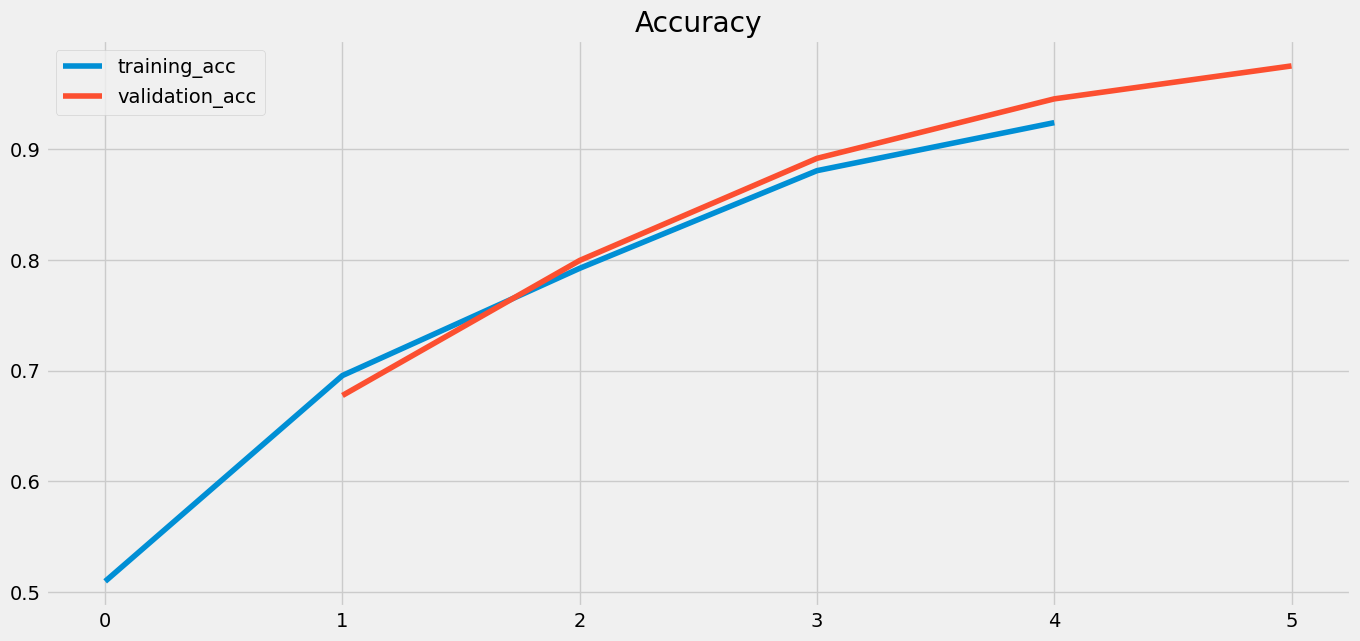

In [122]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=128, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data):
    result = (np.argmax(model.predict(processed_data)[0]) - 1)*-1
    return result 

sample = data_orig[~data_orig["sentiment"].isnull()].sample(frac = 0.9, replace=False)
test = data_orig[~data_orig.isin(sample)].dropna()

#sample = data_aug.iloc[:4659]
#test = data_aug.iloc[[i for i in range(4660, 5176) if i % 4 ==0], ]

model, model_hist = BERT_clasf(sample, 5, 1, 0.33)

TOTAL = len(test.text_final)
pred_sent = []
stage = 0
for tweet in test.text_final:
    print("{}/{}".format(stage, TOTAL))
    processed_data = prepare_data(tweet, tokenizer)
    result = make_prediction(model, processed_data=processed_data)
    pred_sent.append(result)
    stage = stage + 1

In [126]:
trans = {"positive": "[1,0,0]", "neutral": "[0,1,0]", "negative": "[0,0,1]"}
test = test.replace({"sentiment": trans})
Y_test = np.array([np.array(ast.literal_eval(sublist)) for sublist in list(test.sentiment)])

In [ ]:
EPOCHS = 5
VAL_FREQ = 1

sample = data_aug.iloc[:4659]
test = data_aug.iloc[[i for i in range(4660, 5176) if i % 4 ==0], ]

#sample = data_orig[~data_orig["sentiment"].isnull()].sample(frac = 0.9, replace=False)
#test = data_orig[~data_orig.isin(sample)].dropna()
DB = sample

X = DB.text_final
X_test = test.text_final

trans = {"positive": "[1,0,0]", "neutral": "[0,1,0]", "negative": "[0,0,1]"}
DB = DB.replace({"sentiment": trans})
test = test.replace({"sentiment": trans})
Y = np.array([np.array(ast.literal_eval(sublist)) for sublist in list(DB.sentiment)])
Y_test = np.array([np.array(ast.literal_eval(sublist)) for sublist in list(test.sentiment)])

# Separacao entre teste e treino
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, stratify = Y, test_size=0.33)

# Aplicando TD-IDF
tfidf = TfidfVectorizer(use_idf=True)
tfidf.fit(list(X_train))

# Transformando entre token para representativo numerico
X_train = tfidf.transform(list(X_train))
X_val = tfidf.transform(list(X_val))
X_test = tfidf.transform(list(X_test))

# Adaptacao adicional para rede neural
X_train = normalize(X_train.toarray(), axis=0)
X_val = normalize(X_val.toarray(), axis=0)
X_test = normalize(X_test.toarray(), axis=0)
Y_val = np.array(Y_val)
Y_train = np.array(Y_train)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

sequence_input = Input(batch_shape=(None, X_train.shape[1], 1))
gru = Bidirectional(GRU(64, return_sequences = True), name="bi_lstm_0")(sequence_input)

(gru, forward_h, backward_h) = Bidirectional(GRU(128, return_sequences=True, return_state=True), name="bi_lstm_1")(gru)
state_h = Concatenate()([forward_h, backward_h])
context_vector, attention_weights = Attention(10)(gru, state_h) # `lstm` the input features; `state_h` the hidden states from LSTM
dense1 = Dense(64, activation="relu")(context_vector)
dropout = Dropout(0.6)(dense1)
dense2 = Dense(64, activation="relu")(dropout)
output = Dense(3, activation="sigmoid")(dense2)
model = keras.Model(inputs=sequence_input, outputs=output)

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=METRICS)

model_history = model.fit(X_train,Y_train,
                    epochs=EPOCHS,
                    validation_data=(X_val, Y_val),
                    validation_freq=VAL_FREQ, 
                    use_multiprocessing=True)

In [132]:
result = []
for tst in Y_test:
    result.append(np.argmax(tst)*-1 + 1)

Y_pred = model.predict(X_test)

comp = []
for pred in Y_pred:
    comp.append(np.argmax(pred)*-1 + 1)


acc = accuracy_score(result, comp)
mcc = matthews_corrcoef(result, comp)
f1 = f1_score(result, comp, average='weighted')
print("Obteve-se uma acc de {}".format(acc))
print("Obteve-se um mcc de {}".format(mcc))
print("Obteve-se um f1 de {}".format(f1))

5/5 [==============================] - 11s 2s/step


array([[0.42935595, 0.34628192, 0.29512763],
       [0.42952698, 0.3466663 , 0.29561543],
       [0.4294278 , 0.3464432 , 0.29533222],
       [0.42930225, 0.3461611 , 0.29497433],
       [0.4293077 , 0.34617296, 0.29498965],
       [0.42949447, 0.34659302, 0.2955226 ],
       [0.42937827, 0.34633172, 0.2951909 ],
       [0.42933658, 0.3462374 , 0.29507166],
       [0.42944407, 0.34648007, 0.29537898],
       [0.42946473, 0.3465261 , 0.2954376 ],
       [0.42929518, 0.34614474, 0.2949538 ],
       [0.42937756, 0.3463304 , 0.29518914],
       [0.42943734, 0.34646466, 0.29535955],
       [0.42951012, 0.34662813, 0.2955671 ],
       [0.42942923, 0.34644637, 0.29533637],
       [0.42945936, 0.346514  , 0.29542223],
       [0.42935607, 0.34628117, 0.29512686],
       [0.42947653, 0.34655273, 0.29547134],
       [0.42946672, 0.34653074, 0.2954434 ],
       [0.4294298 , 0.34644753, 0.29533795],
       [0.4294332 , 0.34645537, 0.29534775],
       [0.42945534, 0.3465053 , 0.2954111 ],
       [0.

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) # input x weights
        self.W2 = tf.keras.layers.Dense(units) # hidden states h weights
        self.V = tf.keras.layers.Dense(1) # V

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)) ## w[x, h]
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1) ## v tanh(w[x,h])
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features ## attention_weights * x, right now the context_vector shape [batzh_size, max_length, hidden_size]
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


#sample = data_aug.iloc[:4659]
#test = data_aug.iloc[[i for i in range(4660, 5176) if i % 4 ==0], ]

sample = data_orig[~data_orig["sentiment"].isnull()].sample(frac = 0.9, replace=False)
test = data_orig[~data_orig.isin(sample)].dropna()
DB = sample

TOTAL = pd.concat([DB, test], axis=0)
TOTAL = index_tokens(TOTAL)
DB = TOTAL.iloc[:len(DB)]
test = TOTAL.iloc[len(DB):]
EMBEDDING_MATRIX = embedding(DATASOURCE=TOTAL)
MAX_LEN = round(np.max([len(tkns) for tkns in DB.tokens]))+1
X = pad_sequences([sublist for sublist in list(DB.tokens_index)], maxlen=MAX_LEN)
X_test = pad_sequences([sublist for sublist in list(test.tokens_index)], maxlen=X.shape[1])
trans = {"positive": "[1,0,0]", "neutral": "[0,1,0]", "negative": "[0,0,1]"}
DB = DB.replace({"sentiment": trans})
test = test.replace({"sentiment": trans})
Y = np.array([np.array(ast.literal_eval(sublist)) for sublist in list(DB.sentiment)])
Y_test = np.array([np.array(ast.literal_eval(sublist)) for sublist in list(test.sentiment)])
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, stratify = Y, test_size=0.33)

EMB_DIM = EMBEDDING_MATRIX[0].shape[0]
VOCAB_LEN = len(EMBEDDING_MATRIX)
MAX_LEN = X_train.shape[1]
RNN_CELL_SIZE = 32

sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(VOCAB_LEN, EMB_DIM, weights = [EMBEDDING_MATRIX])(sequence_input)
gru = Bidirectional(GRU(128, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(gru, forward_h, backward_h) = Bidirectional(GRU(128, return_sequences=True, return_state=True), name="bi_lstm_1")(gru)
state_h = Concatenate()([forward_h, backward_h])
context_vector, attention_weights = Attention(10)(gru, state_h) # `lstm` the input features; `state_h` the hidden states from LSTM
dense1 = Dense(64, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
dense2 = Dense(64, activation="relu")(dropout)
output = Dense(3, activation="sigmoid")(dense2)
  
model = keras.Model(inputs=sequence_input, outputs=output)

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)


EPOCHS = 10
history = model.fit(X_train,Y_train,
                    epochs=EPOCHS,
                    validation_data=(X_val, Y_val), 
                    validation_freq=2)

In [94]:
np.argmax(Y_pred[0])*-1+1

-1

In [134]:
result = []
for tst in Y_test:
    result.append(np.argmax(tst)*-1 + 1)

In [140]:
model

In [135]:
Y_pred = model.predict(X_test)

5/5 [==============================] - 9s 2s/step


In [136]:
comp = []
for pred in Y_pred:
    comp.append(np.argmax(pred)*-1 + 1)


In [138]:

acc = accuracy_score(result, comp)
mcc = matthews_corrcoef(result, comp)
f1 = f1_score(result, comp, average='weighted')
print("Obteve-se uma acc de {}".format(acc))
print("Obteve-se um mcc de {}".format(mcc))
print("Obteve-se um f1 de {}".format(f1))

Obteve-se uma acc de 0.4108527131782946
Obteve-se um mcc de 0.0
Obteve-se um f1 de 0.23928784393900673


# Relação com o mercado

Analisar existência de correlação entre os movimentos diários do mercado com as análise de sentimento. Para tal, serão considerados para o movimento de mercado:
- S&P500
- Amazon.com
- Apple
- META
- Microsoft

## Predição dos sentimentos

Dentro o universo de tweets não rotulados, estes serão rotulados por meio do melhor modelo. Com isso, tais dados passarão a ser rotulados. Os resultados serão agrupados de forma diária, com positivo = 1, neutro = 0 e negativo = -1.

In [ ]:
sent_clasf = load_model('data/bert')
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=128, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data):
    result = (np.argmax(sent_clasf.predict(processed_data)[0]) - 1)*-1
    return result 

tweets = data[pd.isna(data.sentiment)]
tweets = tweets[~pd.isna(tweets.text_final)]

tickers = [ast.literal_eval(lst) for lst in list(tweets.tickers)]
matchers = ['$SPX', '$SPY', '$AAPL', '$AMZN', '$FB', '$MSFT']
matching = [any(tck in lst for tck in matchers) for lst in tickers]
tweets = tweets[np.array(matching).astype(bool)]

tweets = tweets.sample(60000)
TOTAL = len(tweets.text_final)

pred_sent = []
stage = 0
for tweet in tweets.text_final:
    print("{}/{}".format(stage, TOTAL))
    processed_data = prepare_data(tweet, tokenizer)
    result = make_prediction(sent_clasf, processed_data=processed_data)
    pred_sent.append(result)
    stage = stage + 1

tweets["sentiment"] = pred_sent

tweets.to_excel('data/tweets_clasf.csv', index=False)


## Análise de Correlação

In [49]:
def corr_analy(COMP, TCKRS):
    # Considerar somente para o ticker COMP
    clf = pd.read_csv("data/tweets_clasf.csv")
    clf.created_at = pd.to_datetime(clf.created_at)
    matching = [any(tck in lst for tck in TCKRS) for lst in clf.tickers]
    clf = clf[np.array(matching).astype(bool)]
    clf = clf.sort_values(by=["created_at"], ascending=True)
    clf = clf.groupby(by=clf["created_at"].dt.date).sum().reset_index()[['created_at', 'sentiment']]
    clf.created_at = pd.to_datetime(clf["created_at"]) 

    # Considerando os retornos diarios para COMP
    rtns = pd.read_csv("data/sp_hist_daily.csv", sep=';')
    rtns["created_at"] = pd.to_datetime(rtns["created_at"], dayfirst=True)
    rtns = rtns.sort_values(by=["created_at"], ascending=True)
    rtns = rtns[["created_at", COMP]]

    # Unificando os dados e aplicando os atrasos
    result = clf.merge(rtns, how="outer", on=['created_at'])
    result['return_lag1'] = result[COMP].shift(1)
    result['return_lag3'] = result[COMP].shift(3)
    result['return_lag5'] = result[COMP].shift(5)

    path = "clasf_merc_{}.xlsx".format(COMP)
    result.to_excel(path)

def overall_corr(COMP_LST):
    for comp in COMP_LST:
        if comp == 'SP500':
            corr_analy(comp, ['$SPX', '$SPY'])
        elif comp == 'Microsoft':
            corr_analy(comp, ['$MSFT'])
        elif comp == 'Amazon':
            corr_analy(comp, ['$AMZN'])
        elif comp == 'Apple':
            corr_analy(comp, ['$AAPL'])
        elif comp == 'Meta':
            corr_analy(comp, ['$FB'])

overall_corr(["SP500", "Microsoft", "Amazon", "Apple", "Meta"])